In [ ]:
import pandas as pd

def baskets_parquet_to_transactions(path_parquet):
    b = pd.read_parquet(path_parquet)
    # sets of items
    return [set(items) for items in b["items"]]

#TEST_SIZE = 100

liked_tx  = baskets_parquet_to_transactions("data/processed/baskets_liked_ids.parquet")
#liked_tx = liked_tx[:TEST_SIZE]
hated_tx  = baskets_parquet_to_transactions("data/processed/baskets_hated_ids.parquet")
#hated_tx = hated_tx[:TEST_SIZE]


In [57]:
# choose thresholds appropriate to your basket counts
min_support = 0.01     # e.g., pairs in at least 1% of baskets
min_conf    = 0.4

print("Applying apriori on LIKED...")
frequent_liked = apriori_triangular(liked_tx, min_support)
rules_liked    = generate_rules(frequent_liked, liked_tx, min_conf)
df_rules_liked = pd.DataFrame(rules_liked).sort_values("Lift", ascending=False)
df_rules_liked.to_csv("rules_liked.csv", index=False)

print("Applying apriori on HATED...")
frequent_hated = apriori_triangular(hated_tx, min_support)
rules_hated    = generate_rules(frequent_hated, hated_tx, min_conf)
df_rules_hated = pd.DataFrame(rules_hated).sort_values("Lift", ascending=False)
df_rules_hated.to_csv("rules_hated.csv", index=False)



Applying apriori on LIKED...
Applying apriori on HATED...


In [58]:
frequent_liked[1]

[frozenset({np.int64(3), np.int64(4)}),
 frozenset({np.int64(3), np.int64(7)}),
 frozenset({np.int64(3), np.int64(10)}),
 frozenset({np.int64(3), np.int64(12)}),
 frozenset({np.int64(3), np.int64(18)}),
 frozenset({np.int64(3), np.int64(19)}),
 frozenset({np.int64(3), np.int64(24)}),
 frozenset({np.int64(3), np.int64(28)}),
 frozenset({np.int64(3), np.int64(30)}),
 frozenset({np.int64(3), np.int64(35)}),
 frozenset({np.int64(3), np.int64(39)}),
 frozenset({np.int64(3), np.int64(40)}),
 frozenset({np.int64(3), np.int64(43)}),
 frozenset({np.int64(3), np.int64(46)}),
 frozenset({np.int64(3), np.int64(53)}),
 frozenset({np.int64(3), np.int64(54)}),
 frozenset({np.int64(3), np.int64(56)}),
 frozenset({np.int64(3), np.int64(61)}),
 frozenset({np.int64(3), np.int64(67)}),
 frozenset({np.int64(3), np.int64(75)}),
 frozenset({np.int64(3), np.int64(77)}),
 frozenset({np.int64(3), np.int64(81)}),
 frozenset({np.int64(3), np.int64(82)}),
 frozenset({np.int64(3), np.int64(83)}),
 frozenset({np.int

In [5]:
# save the rules into csv into new_rules_liked.csv and new_rules_hated.csv
df_rules_liked.to_csv("rules_liked.csv", index=False)
df_rules_hated.to_csv("rules_hated.csv", index=False)

In [59]:
print("Rules liked lengh:", len(rules_liked))
print("Rules hated length:", len(rules_hated))

Rules liked lengh: 8411
Rules hated length: 669


In [60]:
import pandas as pd
import ast
import re
from pathlib import Path

DATA_DIR_PROC = Path("data/processed")
CAT_VOCAB     = DATA_DIR_PROC / "cat_vocab.parquet"

# -------------------------------------------------
# 1) Load id -> category mapping
# -------------------------------------------------
id2cat_df  = pd.read_parquet(CAT_VOCAB)
id2cat_map = id2cat_df.set_index("cat_id")["simple_category"].to_dict()

def parse_tuple(s):
    # Make sure we are working with a string
    s = str(s)

    # Special case: "(np.int64(3), np.int64(104), ...)"
    if "np.int64" in s:
        nums = re.findall(r"np\.int64\(\s*(-?\d+)\s*\)", s)
        if nums:
            return tuple(int(n) for n in nums)

        return (s,)

def decode_item(x):
    """
    - If x is an int, map via id2cat_map
    - If it's already a string (liked rules), keep it as is
    """
    if isinstance(x, int):
        return id2cat_map.get(x, f"<UNKNOWN_ID_{x}>")
    return x

def decode_tuple_str(s):
    tup = parse_tuple(s)
    return tuple(decode_item(x) for x in tup)


In [61]:
# Load the rules you already saved
df_rules_liked  = pd.read_csv("rules_liked.csv")
df_rules_hated  = pd.read_csv("rules_hated.csv")

# Create decoded (human-readable) versions
for df in (df_rules_liked, df_rules_hated):
    df["Antecedent_decoded"] = df["Antecedent"].apply(decode_tuple_str)
    df["Consequent_decoded"] = df["Consequent"].apply(decode_tuple_str)


In [62]:
df_rules_liked 

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
0,"(np.int64(3), np.int64(24), np.int64(138))","(np.int64(4), np.int64(122), np.int64(151))",0.010040,0.445312,14.218977,"(American (New), Burgers, Pizza)","(American (Traditional), Mexican, Sandwiches)"
1,"(np.int64(3), np.int64(24), np.int64(151))","(np.int64(4), np.int64(18), np.int64(138))",0.010415,0.443718,13.710395,"(American (New), Burgers, Sandwiches)","(American (Traditional), Breakfast & Brunch, P..."
2,"(np.int64(4), np.int64(43), np.int64(138))","(np.int64(3), np.int64(122), np.int64(151))",0.010244,0.419400,13.684534,"(American (Traditional), Coffee & Tea, Pizza)","(American (New), Mexican, Sandwiches)"
3,"(np.int64(3), np.int64(24), np.int64(151))","(np.int64(4), np.int64(122), np.int64(138))",0.010040,0.427741,13.635664,"(American (New), Burgers, Sandwiches)","(American (Traditional), Mexican, Pizza)"
4,"(np.int64(4), np.int64(24), np.int64(138))","(np.int64(3), np.int64(122), np.int64(151))",0.010040,0.416942,13.604335,"(American (Traditional), Burgers, Pizza)","(American (New), Mexican, Sandwiches)"
...,...,...,...,...,...,...,...
8406,"(np.int64(111),)","(np.int64(3),)",0.011801,0.402208,1.523087,"(Korean,)","(American (New),)"
8407,"(np.int64(106),)","(np.int64(3),)",0.032699,0.401185,1.519215,"(Japanese,)","(American (New),)"
8408,"(np.int64(24),)","(np.int64(3),)",0.048313,0.400745,1.517548,"(Burgers,)","(American (New),)"
8409,"(np.int64(12),)","(np.int64(3),)",0.027341,0.400166,1.515358,"(Barbeque,)","(American (New),)"


In [63]:
df_rules_liked[(df_rules_liked["Antecedent_decoded"].apply(len) == 3) & 
               (df_rules_liked["Support"] > 0.024) & (df_rules_liked["Lift"] > 3)  ]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
5471,"(np.int64(3), np.int64(4), np.int64(18))","(np.int64(138),)",0.024080,0.531011,3.227028,"(American (New), American (Traditional), Break...","(Pizza,)"
5494,"(np.int64(3), np.int64(4), np.int64(18))","(np.int64(151),)",0.025261,0.557073,3.222298,"(American (New), American (Traditional), Break...","(Sandwiches,)"
5794,"(np.int64(3), np.int64(4), np.int64(18))","(np.int64(104),)",0.024347,0.536900,3.153072,"(American (New), American (Traditional), Break...","(Italian,)"


In [64]:
df_rules_liked[(df_rules_liked["Support"] > 0.06)]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
8404,"(np.int64(138),)","(np.int64(4),)",0.065841,0.400124,1.530345,"(Pizza,)","(American (Traditional),)"
8410,"(np.int64(104),)","(np.int64(3),)",0.068136,0.400147,1.515284,"(Italian,)","(American (New),)"


In [65]:
df_rules_hated[(df_rules_hated["Support"] > 0.032)]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
663,"(np.int64(83),)","(np.int64(4),)",0.032292,0.418601,1.449242,"(Grocery,)","(American (Traditional),)"
667,"(np.int64(149),)","(np.int64(4),)",0.032252,0.407206,1.409793,"(Salad,)","(American (Traditional),)"


In [66]:
df_rules_liked[(df_rules_liked["Antecedent_decoded"].apply(len) == 3) & 
               (df_rules_liked["Support"] > 0.024) & (df_rules_liked["Lift"] > 3)  ]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
5471,"(np.int64(3), np.int64(4), np.int64(18))","(np.int64(138),)",0.024080,0.531011,3.227028,"(American (New), American (Traditional), Break...","(Pizza,)"
5494,"(np.int64(3), np.int64(4), np.int64(18))","(np.int64(151),)",0.025261,0.557073,3.222298,"(American (New), American (Traditional), Break...","(Sandwiches,)"
5794,"(np.int64(3), np.int64(4), np.int64(18))","(np.int64(104),)",0.024347,0.536900,3.153072,"(American (New), American (Traditional), Break...","(Italian,)"


In [67]:
len(df_rules_hated.iloc[0]['Antecedent_decoded'])

2

In [68]:
df_rules_hated[(df_rules_hated["Antecedent_decoded"].apply(len) == 1) & 
               (df_rules_hated["Lift"] > 1.5)]

,Antecedent,Consequent,Support,Confidence,Lift,Antecedent_decoded,Consequent_decoded
652,"(np.int64(77),)","(np.int64(3),)",0.014228,0.409849,1.771655,"(Gastropubs,)","(American (New),)"
653,"(np.int64(182),)","(np.int64(4),)",0.017243,0.468373,1.621560,"(Tex-Mex,)","(American (Traditional),)"
654,"(np.int64(121),)","(np.int64(4),)",0.010984,0.440843,1.526247,"(Mediterranean,)","(American (Traditional),)"
655,"(np.int64(12),)","(np.int64(4),)",0.023058,0.437883,1.516002,"(Barbeque,)","(American (Traditional),)"
656,"(np.int64(77),)","(np.int64(4),)",0.015170,0.436991,1.512912,"(Gastropubs,)","(American (Traditional),)"
657,"(np.int64(53),)","(np.int64(4),)",0.013905,0.436971,1.512843,"(Delis,)","(American (Traditional),)"


In [46]:
import pandas as pd

def basket_summary(transactions):
    n_tx = len(transactions)
    items = sorted({i for t in transactions for i in t})
    n_items = len(items)
    avg_size = sum(len(t) for t in transactions) / n_tx
    return pd.DataFrame({
        "Transactions": [n_tx],
        "Unique items": [n_items],
        "Avg basket size": [avg_size],
    })

summary_liked = basket_summary(liked_tx)
summary_hated = basket_summary(hated_tx)

print("LIKED:")
print(summary_liked)
print("\nHATED:")
print(summary_hated)


LIKED:
   Transactions  Unique items  Avg basket size
0        176000           196         4.778256

HATED:
   Transactions  Unique items  Avg basket size
0         74290           193          3.99226


In [46]:
def top_rules(df_rules, k=10, sort_by="Lift"):
    df = df_rules.copy()
    # Format nicely
    df["Antecedent"] = df["Antecedent"].apply(lambda x: ", ".join(map(str, x)))
    df["Consequent"] = df["Consequent"].apply(lambda x: ", ".join(map(str, x)))
    df["Support (%)"] = (df["Support"] * 100).round(2)
    df["Confidence (%)"] = (df["Confidence"] * 100).round(2)
    df["Lift"] = df["Lift"].round(3)
    cols = ["Antecedent", "Consequent", "Support (%)", "Confidence (%)", "Lift"]
    return df.sort_values(sort_by, ascending=False)[cols].head(k)

top_liked = top_rules(df_rules_liked, k=30, sort_by="Lift")
top_hated = top_rules(df_rules_hated, k=30, sort_by="Lift")

print("=== LIKED: Top 10 rules by lift ===")
print(top_liked.to_string(index=False))

print("\n=== HATED: Top 10 rules by lift ===")
print(top_hated.to_string(index=False))


=== LIKED: Top 10 rules by lift ===
   Antecedent Consequent  Support (%)  Confidence (%)  Lift
 43, 104, 152        170         1.01           50.79 5.987
   4, 43, 139         97         1.04           42.82 5.765
  18, 43, 152         97         1.05           42.74 5.753
   4, 43, 152         97         1.11           42.44 5.713
   3, 43, 139         97         1.01           41.86 5.635
   3, 43, 152         97         1.08           41.67 5.609
  18, 43, 104        170         1.07           47.55 5.605
 43, 122, 152        170         1.04           47.54 5.604
   4, 43, 122         97         1.08           41.10 5.532
  18, 43, 122         97         1.04           40.71 5.480
 18, 139, 152         97         1.03           40.69 5.477
   3, 43, 152        170         1.20           46.37 5.466
   3, 43, 104        170         1.14           46.37 5.466
   4, 24, 152         97         1.00           40.60 5.465
   4, 43, 104        170         1.11           46.30 5.457
  18

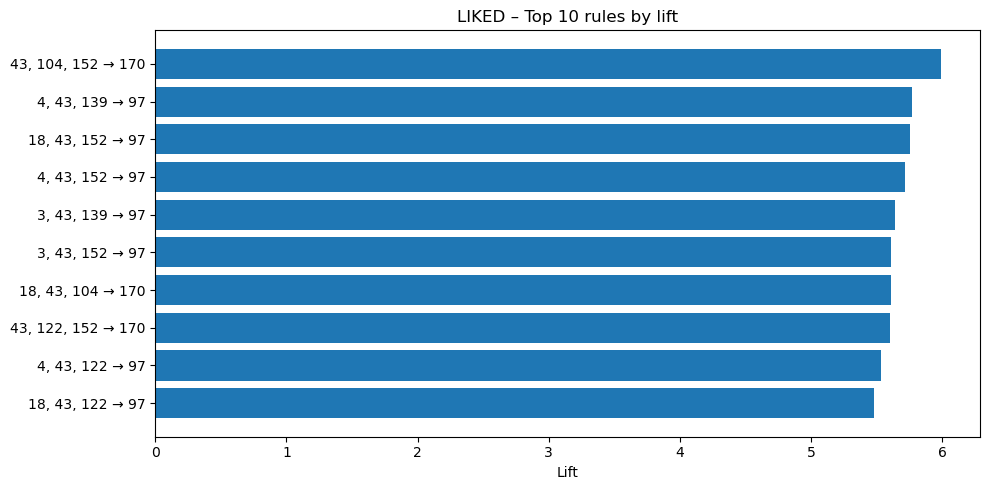

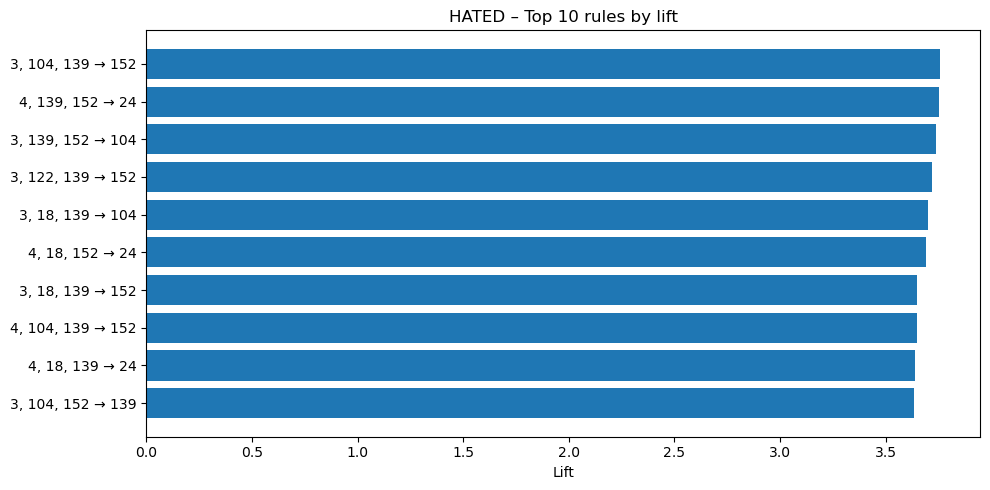

In [47]:
import matplotlib.pyplot as plt

def plot_top_rules(df_rules, k=10, metric="Lift", title="Top rules"):
    df = df_rules.copy()
    df = df.sort_values(metric, ascending=False).head(k)
    labels = [
        f"{', '.join(map(str,a))} → {', '.join(map(str,c))}"
        for a, c in zip(df["Antecedent"], df["Consequent"])
    ]
    values = df[metric]

    plt.figure(figsize=(10, 5))
    plt.barh(range(len(df)), values)
    plt.yticks(range(len(df)), labels)
    plt.gca().invert_yaxis()
    plt.xlabel(metric)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_rules(df_rules_liked, k=10, metric="Lift", title="LIKED – Top 10 rules by lift")
plot_top_rules(df_rules_hated, k=10, metric="Lift", title="HATED – Top 10 rules by lift")


In [48]:
# Ensure same string format for merge
def rules_key_df(df, label):
    tmp = df.copy()
    tmp["Antecedent_str"] = tmp["Antecedent"].apply(lambda x: tuple(sorted(x)))
    tmp["Consequent_str"] = tmp["Consequent"].apply(lambda x: tuple(sorted(x)))
    tmp = tmp[["Antecedent_str", "Consequent_str", "Support", "Confidence", "Lift"]]
    tmp = tmp.rename(columns={
        "Support": f"Support_{label}",
        "Confidence": f"Confidence_{label}",
        "Lift": f"Lift_{label}",
    })
    return tmp

liked_k = rules_key_df(df_rules_liked, "liked")
hated_k = rules_key_df(df_rules_hated, "hated")

merged = liked_k.merge(
    hated_k,
    on=["Antecedent_str", "Consequent_str"],
    how="outer"
)

# Example: rules strong in liked, weak or absent in hated
interesting = merged[
    (merged["Lift_liked"].notna()) &
    ((merged["Lift_hated"].isna()) | (merged["Lift_liked"] > merged["Lift_hated"] + 0.2))
]

# Pick top 10 by Lift_liked
interesting_top = interesting.sort_values("Lift_liked", ascending=False).head(10)
print(interesting_top)


# dump the rules into rules_liked.csv and rules_hated.csv
df_rules_liked.to_csv("rules_liked.csv", index=False)
df_rules_hated.to_csv("rules_hated.csv", index=False)

      Antecedent_str Consequent_str  Support_liked  Confidence_liked  \
3294  (43, 104, 152)         (170,)       0.010076          0.507937   
1487    (4, 43, 139)          (97,)       0.010351          0.428239   
2406   (18, 43, 152)          (97,)       0.010458          0.427390   
1501    (4, 43, 152)          (97,)       0.011110          0.424399   
572     (3, 43, 139)          (97,)       0.010081          0.418632   
586     (3, 43, 152)          (97,)       0.010812          0.416685   
2379   (18, 43, 104)         (170,)       0.010739          0.475479   
3336  (43, 122, 152)         (170,)       0.010385          0.475418   
1477    (4, 43, 122)          (97,)       0.010823          0.410974   
2385   (18, 43, 122)          (97,)       0.010374          0.407105   

      Lift_liked  Support_hated  Confidence_hated  Lift_hated  
3294    5.987113            NaN               NaN         NaN  
1487    5.764827            NaN               NaN         NaN  
2406    5.75339

In [49]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
DATA_PROC = Path("data/processed")

RULES_LIKED_CSV = "rules_liked_library.csv"
RULES_HATED_CSV = "rules_hated_library.csv"

BASKETS_LIKED_IDS = DATA_PROC / "baskets_liked_ids.parquet"
BASKETS_LIKED_STR = DATA_PROC / "baskets_liked_str.parquet"

# -------------------------------------------------------------------
# 1) Load rules
# -------------------------------------------------------------------
df_rules_liked = pd.read_csv(RULES_LIKED_CSV)
df_rules_hated = pd.read_csv(RULES_HATED_CSV)

# -------------------------------------------------------------------
# 2) Build mapping: item_id -> item_label
#
# Assumes:
#   baskets_liked_ids.parquet: columns ["user_id", "items"] where items is list[int]
#   baskets_liked_str.parquet: columns ["user_id", "items"] where items is list[str]
#
# We align by (user_id, position_in_basket) and then deduplicate.
# -------------------------------------------------------------------
ids = pd.read_parquet(BASKETS_LIKED_IDS)
strs = pd.read_parquet(BASKETS_LIKED_STR)

# add position indices inside each basket
ids = ids.copy()
strs = strs.copy()

ids["pos"] = ids["items"].apply(lambda lst: list(range(len(lst))))
strs["pos"] = strs["items"].apply(lambda lst: list(range(len(lst))))

ids_long = ids.explode(["items", "pos"]).rename(columns={"items": "item_id"})
strs_long = strs.explode(["items", "pos"]).rename(columns={"items": "item_label"})

# merge on user_id + position
mapping_long = (
    ids_long[["user_id", "pos", "item_id"]]
    .merge(
        strs_long[["user_id", "pos", "item_label"]],
        on=["user_id", "pos"],
        how="inner",
    )
)

# now drop user/pos, keep unique id -> label
item_map_df = mapping_long[["item_id", "item_label"]].drop_duplicates()

# build dict
id2label = dict(
    zip(
        item_map_df["item_id"].astype(int),
        item_map_df["item_label"].astype(str),
    )
)

print(f"Built mapping for {len(id2label)} unique item IDs.")

# -------------------------------------------------------------------
# 3) Helper to remap Antecedent/Consequent from numbers to strings
# -------------------------------------------------------------------
def remap_side(val):
    """
    Convert a rule side (tuple of np.int64s, list, ndarray, or string
    like '(np.int64(4), np.int64(19))') into labels using id2label.
    """
    # Case 1: already iterable of ints
    if isinstance(val, (tuple, list, np.ndarray)):
        ids = [int(x) for x in val]
    else:
        # Case 2: string or other repr -> extract digits
        s = str(val)
        nums = re.findall(r"\d+", s)  # ['4', '19', ...]
        ids = [int(n) for n in nums]

    # Map to labels
    if len(ids) == 0:
        return ()
    if len(ids) == 1:
        return id2label.get(ids[0], f"<UNK_{ids[0]}>")
    return tuple(id2label.get(i, f"<UNK_{i}>") for i in ids)

# -------------------------------------------------------------------
# 4) Apply to both liked & hated rule tables
# -------------------------------------------------------------------
for df in (df_rules_liked, df_rules_hated):
    df["Antecedent_str"] = df["Antecedent"].apply(remap_side)
    df["Consequent_str"] = df["Consequent"].apply(remap_side)

# -------------------------------------------------------------------
# 4.5) Sort by highest Lift
# -------------------------------------------------------------------
df_rules_liked = df_rules_liked.sort_values("Lift", ascending=False).reset_index(drop=True)
df_rules_hated = df_rules_hated.sort_values("Lift", ascending=False).reset_index(drop=True)

# -------------------------------------------------------------------
# 5) Inspect
# -------------------------------------------------------------------
print("\n=== LIKED RULES (top 100 by Lift) ===")
print(df_rules_liked[["Antecedent_str", "Consequent_str", "Lift"]].head(100))

print("\n=== HATED RULES (top 100 by Lift) ===")
print(df_rules_hated[["Antecedent_str", "Consequent_str", "Lift"]].head(100))

# -------------------------------------------------------------------
# 6) Save human-readable versions
# -------------------------------------------------------------------
df_rules_liked.to_csv("rules_liked_human.csv", index=False)
df_rules_hated.to_csv("rules_hated_human.csv", index=False)


Built mapping for 197 unique item IDs.

=== LIKED RULES (top 100 by Lift) ===
                                       Antecedent_str  \
0   (Ethiopian, American (New), Ethiopian, Burgers...   
1   (Ethiopian, American (Traditional), Ethiopian,...   
2   (Ethiopian, American (New), Ethiopian, Burgers...   
3   (Ethiopian, American (New), Ethiopian, Burgers...   
4   (Ethiopian, American (New), Ethiopian, Burgers...   
..                                                ...   
95  (Ethiopian, Breakfast & Brunch, Ethiopian, Cof...   
96  (Ethiopian, Breakfast & Brunch, Ethiopian, Piz...   
97  (Ethiopian, Breakfast & Brunch, Ethiopian, Ita...   
98  (Ethiopian, American (New), Ethiopian, America...   
99  (Ethiopian, American (New), Ethiopian, Pizza, ...   

                                       Consequent_str       Lift  
0   (Ethiopian, American (Traditional), Ethiopian,...  13.854977  
1   (Ethiopian, American (New), Ethiopian, Mexican...  13.828843  
2   (Ethiopian, American (Traditiona

In [15]:
import pandas as pd

liked_ids  = pd.read_parquet("data/processed/baskets_liked_ids.parquet")
liked_str  = pd.read_parquet("data/processed/baskets_liked_str.parquet")

print("LIKED IDS columns:", liked_ids.columns.tolist())
print("LIKED STR columns:", liked_str.columns.tolist())

liked_ids.head()
liked_str.head()


LIKED IDS columns: ['user_id', 'items']
LIKED STR columns: ['user_id', 'items']


,user_id,items
0,---2PmXbF47D870stH1jqA,"[American (New), American (Traditional), Break..."
1,---UgP94gokyCDuB5zUssA,"[American (New), Cafes, Cajun/Creole, Italian,..."
2,--6PFZka7og6Khaw6oyjvQ,"[Chicken Shop, Chinese, Mexican]"
3,--KsuCSkGGvDKTbdK9NvIg,"[American (New), American (Traditional), Barbe..."
4,--T_QxqWcEu76n1daMmlLQ,"[American (New), Breakfast & Brunch, Convenien..."


In [18]:
import pandas as pd
from itertools import combinations

# ---------------------------------------------------------------------
# Your existing functions (keep as they are)
# ---------------------------------------------------------------------
# get_transactions(...)
# pair_index(...)
# support(itemset, transactions)
# apriori_triangular(transactions, min_support)
# generate_rules(frequent_itemsets, transactions, min_conf)
#
# And you already have:
# liked_tx: list[set[int]]   # with integer category IDs
# hated_tx: list[set[int]]   # with integer category IDs


# ---------------------------------------------------------------------
# Build mapping: integer category ID -> string category label
# ---------------------------------------------------------------------
def build_id2label(
    ids_path: str,
    str_path: str,
    list_col: str = "items",
) -> dict:
    """
    Recover mapping from integer category IDs to string labels by aligning
    the liked baskets with IDs and with strings.

    ids_path : parquet file with list-of-INT categories
    str_path : parquet file with list-of-STRING categories
    list_col : name of column in both files that holds the list
               (here: 'items')
    """
    ids_df = pd.read_parquet(ids_path)
    str_df = pd.read_parquet(str_path)

    # Explode list columns to one row per item
    long_ids = (
        ids_df[[list_col]]
        .explode(list_col)
        .rename(columns={list_col: "cat_id"})
    )
    long_str = (
        str_df[[list_col]]
        .explode(list_col)
        .rename(columns={list_col: "cat_label"})
    )

    # Align rows by index (same row i in both = same user/basket position)
    mapping_df = pd.concat(
        [long_ids["cat_id"], long_str["cat_label"]],
        axis=1
    ).dropna().drop_duplicates()

    id2label = dict(zip(mapping_df["cat_id"], mapping_df["cat_label"]))
    return id2label


# ---------------------------------------------------------------------
# Summary functions with optional id2label mapping
# ---------------------------------------------------------------------
def summary_itemsets(transactions, frequent_itemsets, min_support, name="", id2label=None):
    """Print compact summary for Apriori frequent itemsets, with optional ID→label remap."""
    n_tx = len(transactions)
    all_items = set().union(*transactions)
    min_count = min_support * n_tx

    if name:
        print(f"\n=== APRIORI SUMMARY: {name} ===")
    else:
        print("\n=== APRIORI SUMMARY ===")

    print(f"Transactions:          {n_tx}")
    print(f"Unique items:          {len(all_items)}")
    print(f"Avg basket size:       {sum(len(t) for t in transactions) / n_tx:.2f}")
    print(f"Min support:           {min_support:.2%}  (~{min_count:.0f} transactions)")

    total_frequent = 0
    for k, Lk in enumerate(frequent_itemsets, start=1):
        if not Lk:
            continue
        count_k = len(Lk)
        total_frequent += count_k
        print(f"  Size {k} itemsets:   {count_k}")
    print(f"Total frequent sets:   {total_frequent}")

    def fmt_item(item):
        if id2label is not None:
            return str(id2label.get(item, item))
        return str(item)

    # Top 5 itemsets per size by support
    for k, Lk in enumerate(frequent_itemsets, start=1):
        if not Lk:
            continue
        itemset_supports = [(itemset, support(itemset, transactions)) for itemset in Lk]
        itemset_supports.sort(key=lambda x: x[1], reverse=True)
        top = itemset_supports[:5]

        print(f"\nTop itemsets (size {k}):")
        for s, sup in top:
            items_str = ", ".join(fmt_item(x) for x in sorted(s))
            print(f"  {{{items_str}}} | support={sup:.2%}")


def summary_rules(df_rules, name="", id2label=None):
    """Print compact summary for association rules, with optional ID→label remap."""
    if name:
        print(f"\n=== RULES SUMMARY: {name} ===")
    else:
        print("\n=== RULES SUMMARY ===")

    n_rules = len(df_rules)
    print(f"Total rules:           {n_rules}")
    if n_rules == 0:
        return

    print(f"Avg confidence:        {df_rules['Confidence'].mean():.2%}")
    print(f"Avg lift:              {df_rules['Lift'].mean():.2f}")
    print(f"Avg support:           {df_rules['Support'].mean():.2%}")

    def fmt_item(item):
        if id2label is not None:
            return str(id2label.get(item, item))
        return str(item)

    def fmt_itemset(iset):
        return "{" + ", ".join(fmt_item(x) for x in sorted(iset)) + "}"

    top = df_rules.sort_values("Lift", ascending=False).head(5)
    print("\nTop rules by lift:")
    for _, row in top.iterrows():
        ant = fmt_itemset(row["Antecedent"])
        cons = fmt_itemset(row["Consequent"])
        print(f"  {ant} -> {cons}")
        print(
            f"     conf={row['Confidence']:.2%}, "
            f"lift={row['Lift']:.2f}, "
            f"supp={row['Support']:.2%}"
        )


# ---------------------------------------------------------------------
# MAIN ANALYSIS
# ---------------------------------------------------------------------
if __name__ == "__main__":
    liked_ids_path = "data/processed/baskets_liked_ids.parquet"
    liked_str_path = "data/processed/baskets_liked_str.parquet"

    # both use column name 'items'
    id2label = build_id2label(
        liked_ids_path,
        liked_str_path,
        list_col="items",
    )

    # Parameters for Apriori
    min_support = 0.01   # at least 1% of baskets
    min_conf    = 0.40   # 40% confidence

    # ---- LIKED ----
    frequent_liked = apriori_triangular(liked_tx, min_support)
    summary_itemsets(liked_tx, frequent_liked, min_support, name="LIKED", id2label=id2label)

    rules_liked = generate_rules(frequent_liked, liked_tx, min_conf)
    df_rules_liked = pd.DataFrame(rules_liked)
    summary_rules(df_rules_liked, name="LIKED", id2label=id2label)

    # ---- HATED ----
    frequent_hated = apriori_triangular(hated_tx, min_support)
    summary_itemsets(hated_tx, frequent_hated, min_support, name="HATED", id2label=id2label)

    rules_hated = generate_rules(frequent_hated, hated_tx, min_conf)
    df_rules_hated = pd.DataFrame(rules_hated)
    summary_rules(df_rules_hated, name="HATED", id2label=id2label)

    # ---- SIMPLE COMPARISON ----
    print("\n=== LIKED vs HATED COMPARISON ===")
    print(f"Transactions (LIKED):  {len(liked_tx)}")
    print(f"Transactions (HATED):  {len(hated_tx)}")
    print(f"Rules (LIKED):         {len(df_rules_liked)}")
    print(f"Rules (HATED):         {len(df_rules_hated)}")

    if len(df_rules_liked) > 0 and len(df_rules_hated) > 0:
        print(f"Avg lift LIKED:        {df_rules_liked['Lift'].mean():.2f}")
        print(f"Avg lift HATED:        {df_rules_hated['Lift'].mean():.2f}")
        print(f"Avg conf LIKED:        {df_rules_liked['Confidence'].mean():.2%}")
        print(f"Avg conf HATED:        {df_rules_hated['Confidence'].mean():.2%}")



=== APRIORI SUMMARY: LIKED ===
Transactions:          173059
Unique items:          150
Avg basket size:       4.32
Min support:           1.00%  (~1731 transactions)
  Size 1 itemsets:   59
  Size 2 itemsets:   210
  Size 3 itemsets:   127
  Size 4 itemsets:   81
  Size 5 itemsets:   21
Total frequent sets:   498

Top itemsets (size 1):
  {American (New)} | support=53.25%
  {American (Traditional)} | support=40.70%
  {Breakfast & Brunch} | support=30.14%
  {Mexican} | support=21.72%
  {Italian} | support=21.27%

Top itemsets (size 2):
  {American (New), American (Traditional)} | support=23.99%
  {American (New), Breakfast & Brunch} | support=18.31%
  {American (Traditional), Breakfast & Brunch} | support=14.35%
  {American (New), Asian Fusion} | support=8.90%
  {American (New), Burgers} | support=7.54%

Top itemsets (size 3):
  {American (New), American (Traditional), Breakfast & Brunch} | support=10.42%
  {American (New), American (Traditional), Asian Fusion} | support=5.54%
  {Amer

In [ ]:
# Load the results
df_rules_liked = pd.read_csv("rules_liked.csv")
df_rules_hated = pd.read_csv("rules_hated.csv")

# remap the numbers into strings 



# Basic stats
print("=== LIKED RULES ===")
print(f"Total rules: {len(df_rules_liked)}")
print(f"\nTop 10 by Lift:")
print(df_rules_liked.head(10))

print("\n=== HATED RULES ===")
print(f"Total rules: {len(df_rules_hated)}")
print(f"\nTop 10 by Lift:")
print(df_rules_hated.head(10))

=== LIKED RULES ===
Total rules: 791

Top 10 by Lift:
                                  Antecedent  \
0  (np.int64(4), np.int64(19), np.int64(38))   
1  (np.int64(4), np.int64(11), np.int64(19))   
2  (np.int64(4), np.int64(11), np.int64(19))   
3  (np.int64(4), np.int64(19), np.int64(28))   
4  (np.int64(4), np.int64(19), np.int64(38))   
5                (np.int64(7), np.int64(38))   
6  (np.int64(3), np.int64(11), np.int64(19))   
7  (np.int64(4), np.int64(11), np.int64(19))   
8               (np.int64(11), np.int64(24))   
9               (np.int64(11), np.int64(38))   

                                 Consequent   Support  Confidence      Lift  
0               (np.int64(3), np.int64(11))  0.012857    0.400036  7.585167  
1               (np.int64(3), np.int64(38))  0.012857    0.440769  7.130876  
2               (np.int64(3), np.int64(28))  0.012972    0.444731  6.884751  
3               (np.int64(3), np.int64(38))  0.013984    0.419265  6.782991  
4               (np.int64(3

In [13]:
# Distribution of metrics
print("\n=== Metric Distributions ===")
print(df_rules_liked[['Support', 'Confidence', 'Lift']].describe())

# High-value rules (strong associations)
print("\n=== Strong Rules (Lift > 2, Confidence > 0.6) ===")
strong_liked = df_rules_liked[(df_rules_liked['Lift'] > 2) & 
                               (df_rules_liked['Confidence'] > 0.6)]
print(strong_liked[['Antecedent', 'Consequent', 'Confidence', 'Lift']])


=== Metric Distributions ===
           Support   Confidence         Lift
count  3711.000000  3711.000000  3711.000000
mean      0.019243     0.860938    12.566533
std       0.018822     0.210933    12.626569
min       0.010000     0.411765     0.746269
25%       0.010000     0.666667     4.545455
50%       0.010000     1.000000     9.090909
75%       0.030000     1.000000    16.666667
max       0.380000     1.000000   100.000000

=== Strong Rules (Lift > 2, Confidence > 0.6) ===
                                             Antecedent  \
0                                       (np.int64(14),)   
1                            (np.int64(4), np.int64(8))   
2                                       (np.int64(14),)   
3                            (np.int64(2), np.int64(3))   
4                            (np.int64(4), np.int64(5))   
...                                                 ...   
3277                                    (np.int64(23),)   
3278           (np.int64(4), np.int64(7), 

In [11]:
print("=== DATASET SIZES ===")
print(f"Liked transactions: {len(liked_tx)}")
print(f"Hated transactions: {len(hated_tx)}")

# Count unique items
liked_items = set(item for tx in liked_tx for item in tx)
hated_items = set(item for tx in hated_tx for item in tx)

print(f"\nUnique items in LIKED: {len(liked_items)}")
print(f"Unique items in HATED: {len(hated_items)}")

# Average basket size
liked_avg = sum(len(tx) for tx in liked_tx) / len(liked_tx)
hated_avg = sum(len(tx) for tx in hated_tx) / len(hated_tx)

print(f"\nAverage basket size LIKED: {liked_avg:.2f}")
print(f"Average basket size HATED: {hated_avg:.2f}")

=== DATASET SIZES ===
Liked transactions: 173059
Hated transactions: 43759

Unique items in LIKED: 150
Unique items in HATED: 148

Average basket size LIKED: 4.32
Average basket size HATED: 3.11


In [13]:
import pandas as pd
from pathlib import Path

LIKED_CSV = Path("rules_liked.csv")
HATED_CSV = Path("rules_hated.csv")

def load_rules(path):
    df = pd.read_csv(path)
    # ensure consistent schema
    # expected cols: ["Antecedent","Consequent","Support","Confidence","Lift"] (+ maybe Count, etc.)
    # normalize types
    for c in ["Support","Confidence","Lift"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    # make a canonical string form for easy joins/comparisons
    def canon(items):
        if isinstance(items, str):
            parts = [x.strip() for x in items.strip("{}[]()").split(",") if x.strip()]
            return tuple(sorted(parts))
        if isinstance(items, (list, tuple, set)):
            return tuple(sorted(items))
        return (str(items),)

    df["A"] = df["Antecedent"].apply(canon)
    df["B"] = df["Consequent"].apply(canon)
    df["rule_str"] = df["A"].apply(lambda t: "{" + ", ".join(t) + "}") + " → " + df["B"].apply(lambda t: "{" + ", ".join(t) + "}")
    return df

liked = load_rules(LIKED_CSV)
hated = load_rules(HATED_CSV)

len(liked), len(hated), liked.head(3)


(791,
 29,
                                   Antecedent                   Consequent  \
 0  (np.int64(4), np.int64(19), np.int64(38))  (np.int64(3), np.int64(11))   
 1  (np.int64(4), np.int64(11), np.int64(19))  (np.int64(3), np.int64(38))   
 2  (np.int64(4), np.int64(11), np.int64(19))  (np.int64(3), np.int64(28))   
 
     Support  Confidence      Lift                                         A  \
 0  0.012857    0.400036  7.585167  (np.int64(19), np.int64(38, np.int64(4))   
 1  0.012857    0.440769  7.130876  (np.int64(11), np.int64(19, np.int64(4))   
 2  0.012972    0.444731  6.884751  (np.int64(11), np.int64(19, np.int64(4))   
 
                             B  \
 0  (np.int64(11, np.int64(3))   
 1  (np.int64(3), np.int64(38)   
 2  (np.int64(28, np.int64(3))   
 
                                             rule_str  
 0  {np.int64(19), np.int64(38, np.int64(4)} → {np...  
 1  {np.int64(11), np.int64(19, np.int64(4)} → {np...  
 2  {np.int64(11), np.int64(19, np.int64(4)} → 

In [21]:
liked.nlargest(100, "Lift")[["rule_str","Support","Confidence","Lift"]]


,rule_str,Support,Confidence,Lift
0,"{np.int64(19), np.int64(38, np.int64(4)} → {np...",0.012857,0.400036,7.585167
1,"{np.int64(11), np.int64(19, np.int64(4)} → {np...",0.012857,0.440769,7.130876
2,"{np.int64(11), np.int64(19, np.int64(4)} → {np...",0.012972,0.444731,6.884751
3,"{np.int64(19), np.int64(28, np.int64(4)} → {np...",0.013984,0.419265,6.782991
4,"{np.int64(19), np.int64(38, np.int64(4)} → {np...",0.013984,0.435095,6.735590
...,...,...,...,...
95,"{np.int64(24), np.int64(28} → {np.int64(19, np...",0.015093,0.647817,4.513493
96,"{np.int64(24), np.int64(38} → {np.int64(19, np...",0.014625,0.647812,4.513452
97,"{np.int64(11), np.int64(28} → {np.int64(19, np...",0.013527,0.644904,4.493191
98,"{np.int64(19), np.int64(38, np.int64(4)} → {np...",0.014677,0.456670,4.489372


In [24]:
liked_strong = liked.query("Support >= 0.01 and Confidence >= 0.5").copy()


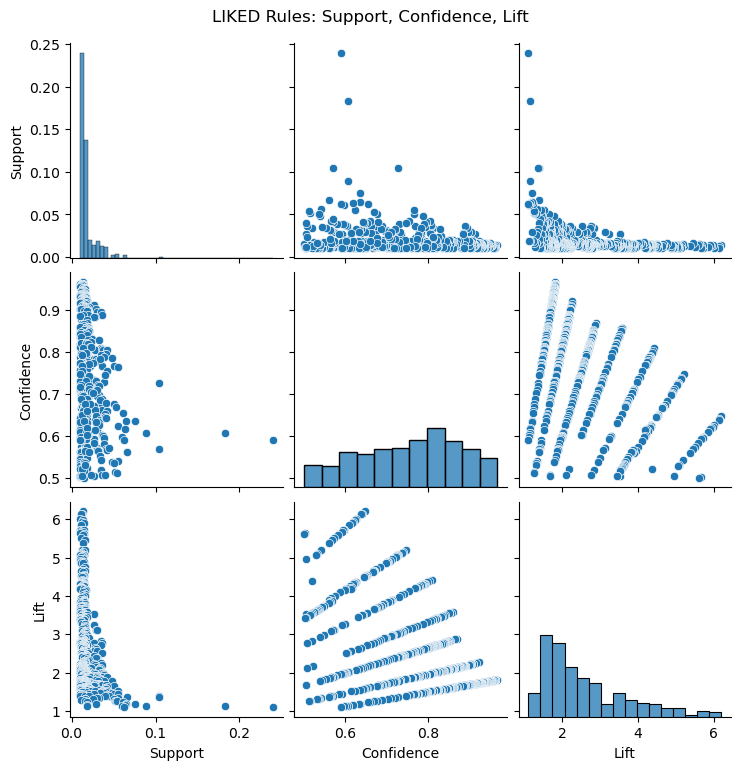

In [25]:
# visualize liked_strong
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(liked_strong[["Support","Confidence","Lift"]])
plt.suptitle("LIKED Rules: Support, Confidence, Lift", y=1.02)
plt.show()

In [29]:
# Filter to robust rules (tune thresholds to your basket counts)
robust = df_tidy.query("Support >= 0.01 and Confidence >= 0.5").copy()

# Remove overlap between A and B (rare but possible with messy strings)
robust = robust[[set(a).isdisjoint(set(b)) for a,b in zip(robust["A_ids"], robust["B_ids"])]]

# Spot “too good to be true”: huge lift but tiny support
suspicious = df_tidy.query("Support < 0.005 and Lift > 5")


NameError: name 'df_tidy' is not defined

In [31]:
# keep only singletons on both sides
one_to_one = [
    d for d in association_rules
    if len(d["Antecedent"]) == 1 and len(d["Consequent"]) == 1
]

# sort by highest lift
one_to_one_sorted = sorted(one_to_one, key=lambda d: d["Lift"], reverse=True)

for d in one_to_one_sorted:
    a = list(d["Antecedent"])[0]
    b = list(d["Consequent"])[0]
    print(f"{{{a}}} → {{{b}}} | support={d['Support']:.4f} conf={d['Confidence']:.4f} lift={d['Lift']:.3f}")


NameError: name 'association_rules' is not defined

In [34]:


from efficient_apriori import apriori

item_sets, association_rules = apriori(hated_tx, min_support=0.03, min_confidence=0.3)

# Get 1 to 1 rules e.g. {bread} -> {butter}
one_to_one_rules = filter(
    lambda rule: len(rule.lhs) == 1 and len(rule.rhs) == 1, association_rules
)
for rule in sorted(one_to_one_rules, key=lambda rule: rule.lift):
    print(rule)



{24} -> {3} (conf: 0.385, supp: 0.063, lift: 0.937, conv: 0.958)
{7} -> {4} (conf: 0.379, supp: 0.037, lift: 0.962, conv: 0.976)
{38} -> {3} (conf: 0.397, supp: 0.031, lift: 0.965, conv: 0.976)
{36} -> {3} (conf: 0.400, supp: 0.044, lift: 0.972, conv: 0.981)
{90} -> {3} (conf: 0.404, supp: 0.032, lift: 0.983, conv: 0.988)
{102} -> {3} (conf: 0.409, supp: 0.069, lift: 0.995, conv: 0.997)
{4} -> {3} (conf: 0.416, supp: 0.164, lift: 1.012, conv: 1.008)
{3} -> {4} (conf: 0.399, supp: 0.164, lift: 1.012, conv: 1.008)
{19} -> {4} (conf: 0.401, supp: 0.084, lift: 1.019, conv: 1.012)
{102} -> {4} (conf: 0.402, supp: 0.068, lift: 1.019, conv: 1.012)
{38} -> {4} (conf: 0.403, supp: 0.032, lift: 1.023, conv: 1.015)
{7} -> {3} (conf: 0.422, supp: 0.041, lift: 1.027, conv: 1.019)
{36} -> {4} (conf: 0.406, supp: 0.045, lift: 1.030, conv: 1.020)
{19} -> {3} (conf: 0.425, supp: 0.088, lift: 1.033, conv: 1.024)
{114} -> {3} (conf: 0.426, supp: 0.039, lift: 1.035, conv: 1.025)
{72} -> {3} (conf: 0.427, 

In [35]:
from math import sqrt, log
import pandas as pd

def supports_dict(item_sets):
    # Flatten {k: {frozenset(...): support, ...}} -> {frozenset(...): support}
    s = {}
    for k, d in item_sets.items():
        s.update(d)
    return s

def rules_to_df(rules, sup_map):
    rows = []
    for r in rules:
        lhs = frozenset(r.lhs)
        rhs = frozenset(r.rhs)
        pA  = sup_map.get(lhs, None)
        pB  = sup_map.get(rhs, None)
        pAB = r.support
        if pA is None or pB is None:  # safety
            continue

        # Core derived probs
        pB_given_A   = pAB / pA if pA else 0.0
        pB_given_notA = (pB - pAB) / (1 - pA) if (1 - pA) > 0 else float("nan")

        # Robust metrics
        leverage   = pAB - pA*pB                       # additive effect
        risk_diff  = pB_given_A - pB_given_notA        # absolute risk difference
        RR         = (pB_given_A / pB_given_notA) if pB_given_notA and pB_given_notA>0 else float("inf")
        PMI        = log( (pAB + 1e-12) / ((pA+1e-12)*(pB+1e-12)) )
        nPMI       = PMI / (-log(pAB + 1e-12))
        jaccard    = pAB / (pA + pB - pAB + 1e-12)
        cosine     = pAB / sqrt((pA+1e-12)*(pB+1e-12))
        # Conviction can be rederived; r.conviction may already exist
        conviction = (1 - pB) / (1 - r.confidence + 1e-12)

        rows.append({
            "lhs": lhs, "rhs": rhs,
            "support": r.support,
            "confidence": r.confidence,
            "lift": r.lift,
            "conviction": conviction,
            "pA": pA, "pB": pB, "pAB": pAB,
            "leverage": leverage,
            "risk_diff": risk_diff,
            "RR": RR,
            "PMI": PMI, "nPMI": nPMI,
            "jaccard": jaccard, "cosine": cosine
        })
    return pd.DataFrame(rows)

# Usage
item_sets, rules = apriori(hated_tx, min_support=0.03, min_confidence=0.3)
sup_map = supports_dict(item_sets)
df = rules_to_df(rules, sup_map)

# Popularity-robust sorting:
top = df.query("support >= 0.03").sort_values(["leverage","RR","nPMI"], ascending=False).head(50)


UndefinedVariableError: name 'support' is not defined